# LRP using Abstract Semiring elements for the VGG-16 Network

## 0. Loading

In [29]:
import cv2
import torch
import torchvision
import numpy as np
import utils

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [47]:
img = np.array(cv2.imread('images/zebra.jpg'))[...,::-1]/255.0

# values from https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [48]:
model = torchvision.models.vgg16(pretrained=True); model.eval()
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)

## 1. Class prediction

In [49]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

In [50]:
scores = np.array(A[-1].data.view(-1))
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

               zebra (340): 26.106
          hartebeest (351): 16.157
             gazelle (353): 14.829
tiger, Panthera tigr (292): 13.599
ostrich, Struthio ca (  9): 13.377
impala, Aepyceros me (352): 13.366
       hyena, hyaena (276): 13.070
African elephant, Lo (386): 12.447
             warthog (343): 11.365
cheetah, chetah, Aci (293): 11.340


## 2. LRP

In [51]:
T = torch.FloatTensor((1.0*(np.arange(1000)==483).reshape([1,1000,1,1])))

In [52]:
R = [None]*L + [(A[-1]*T).data]

In [53]:
for l in range(1,L)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:       
            rho = lambda p: p + 0.25*p.clamp(min=0)
            incr = lambda z: z+1e-9
        if 17 <= l <= 30: 
            rho = lambda p: p 
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:
            rho = lambda p: p
            incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))
        s = (R[l+1]/z).data
        (z*s).sum().backward()
        c = A[l].grad
        R[l] = (A[l]*c).data
        
    else:
        
        R[l] = R[l+1]

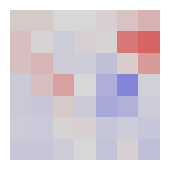

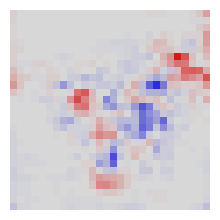

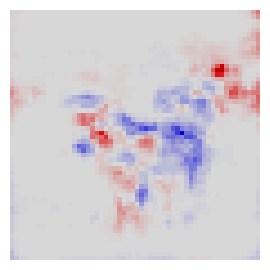

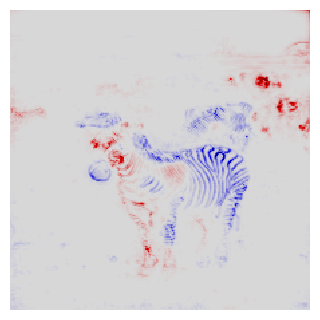

In [54]:
for i,l in enumerate([31,21,11,1]):
    utils.heatmap(np.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

In [55]:
A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9
z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)
z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)
s = (R[1]/z).data
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad
R[0] = (A[0]*c+lb*cp+hb*cm).data

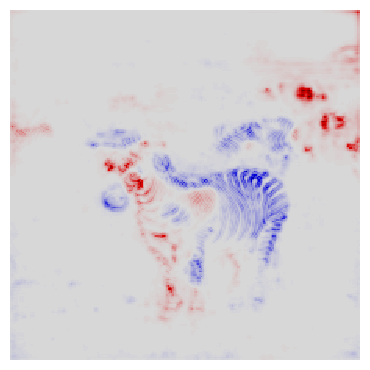

In [56]:
utils.heatmap(np.array(R[0][0]).sum(axis=0),3.5,3.5)

### 3. LRP Simplification
Instead of a rafined setup, we consider $\epsilon=0$, $\rho(x)=x$, we do not normalize the relevance, and we apply the LRP-0 rule for every layer, including the last one (no $z^\mathcal{B}$).

In [57]:
R_simp = [None]*L + [(A[-1]*T).data]

In [58]:
for l in range(0,L)[::-1]:
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        rho = lambda p: p
        incr = lambda z: z

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))
        s = (R[l+1]).data
        (z*s).sum().backward()
        c = A[l].grad
        R_simp[l] = (A[l]*c).data
        
    else:
        R_simp[l] = R_simp[l+1]

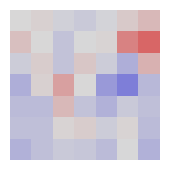

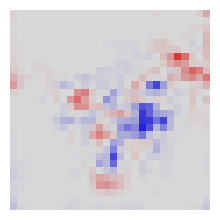

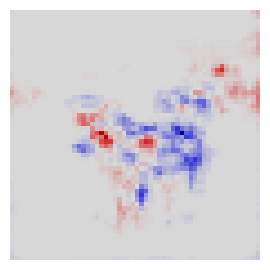

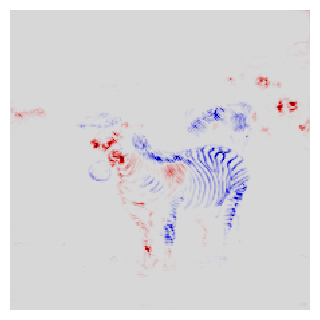

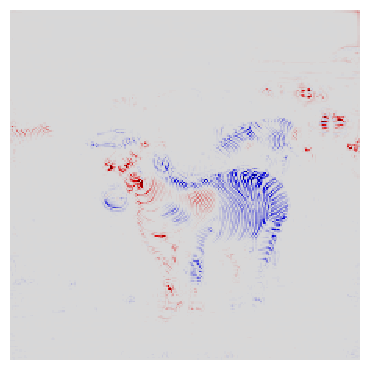

In [59]:
for i,l in enumerate([31,21,11,1, 0]):
    utils.heatmap(np.array(R_simp[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

### Comparaison of the methods

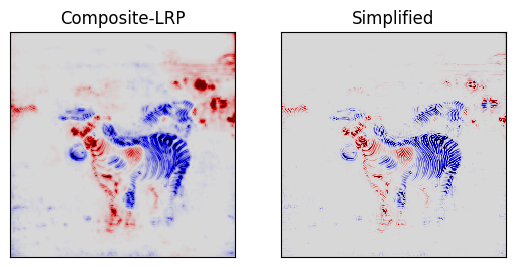

In [60]:
my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)

fig, axs = plt.subplots(1, 2)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

b = 10*(np.abs(np.array(R[0][0]))**3.0).mean()**(1.0/3)
axs[0].imshow(np.array(R[0][0]).sum(axis=0), cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
axs[0].set_title("Composite-LRP")


b = 10*(np.abs(np.array(R_simp[0][0]))**3.0).mean()**(1.0/3)
axs[1].imshow(np.array(R_simp[0][0]).sum(axis=0),cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
axs[1].set_title("Simplified")

plt.show()